Submission File Format
You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

PassengerId (sorted in any order)
Survived (contains your binary predictions: 1 for survived, 0 for deceased)
PassengerId,Survived
892,0
893,1
894,0
Etc.

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [35]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Change "Sex" and "Embarked" variables to int so we can visualize them later

For binary variables like Yes/No, manual mapping or LabelEncoder work best. For multiple categories without inherent order, consider one-hot encoding to avoid implying false ordinal relationships.

In [36]:
train['Sex'] = train['Sex'].map({"male": 0, "female": 1})
train['Embarked'] = train['Embarked'].map({"C": 0, "Q": 1, "S": 2})

test['Sex'] = test['Sex'].map({"male": 0, "female": 1})
test['Embarked'] = test['Embarked'].map({"C": 0, "Q": 1, "S": 2})

Remove useless variables: PassengerId, Name, Ticket, Cabin \
This will cause the appereance of duplicated rows, but they are not really duplicated, we know that there are no real duplicated rows

In [37]:
print("Duplicated rows in train:")
print(train[train.duplicated()])

print("Duplicated rows in test:")
test[test.duplicated()]

Duplicated rows in train:
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
Duplicated rows in test:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [38]:
train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

## Data Preparation

### 1º) First glanze at the data

See the data and its characteristics (shape, types, null values, missing rows, duplicated rows, class/data imbalances...)

In [39]:
print(train.shape)
print(test.shape)

(891, 8)
(418, 7)


In [40]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0
5,0,3,0,NaN,0,0,8.4583,1.0
6,0,1,0,54.0,0,0,51.8625,2.0
7,0,3,0,2.0,3,1,21.0750,2.0
8,1,3,1,27.0,0,2,11.1333,2.0
9,1,2,1,14.0,1,0,30.0708,0.0


In [41]:
test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,2
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,2
4,3,1,22.0,1,1,12.2875,2
5,3,0,14.0,0,0,9.2250,2
6,3,1,30.0,0,0,7.6292,1
7,2,0,26.0,1,1,29.0000,2
8,3,1,18.0,0,0,7.2292,0
9,3,0,21.0,2,0,24.1500,2


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


Check for missing values, missing rows, duplicated rows

In [44]:
train_count_missval = train.isna().sum()
print(train_count_missval[train_count_missval > 0])
print(train_count_missval[train_count_missval > 0]/train.shape[0] * 100)

Age         177
Embarked      2
dtype: int64
Age         19.865320
Embarked     0.224467
dtype: float64


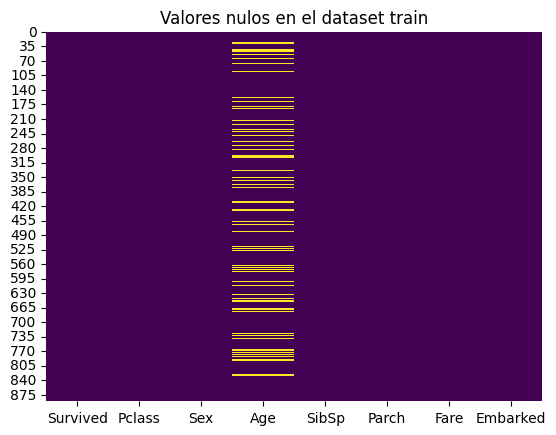

In [45]:
# Visualizar con heatmap
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Valores nulos en el dataset train")
plt.show()

In [46]:
test_count_missval = test.isna().sum()

print(test_count_missval[test_count_missval > 0])
print(test_count_missval[test_count_missval > 0]/test.shape[0] * 100)

Age     86
Fare     1
dtype: int64
Age     20.574163
Fare     0.239234
dtype: float64


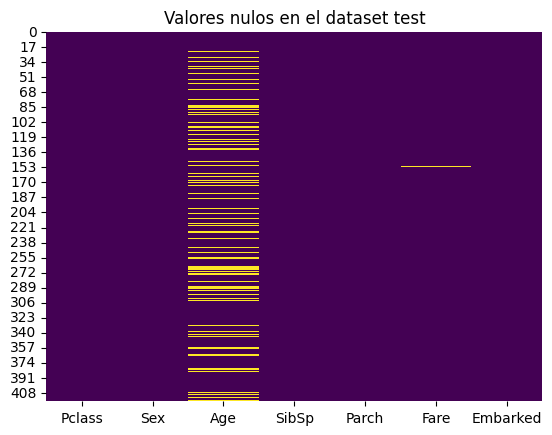

In [47]:
# Visualizar con heatmap
sns.heatmap(test.isnull(), cbar=False, cmap="viridis")
plt.title("Valores nulos en el dataset test")
plt.show()

In [48]:
print(f"Number of missing rows in train: {len(train[train.isnull().all(axis=1)]) }")

print(f"Number of missing rows in test: {len(test[test.isnull().all(axis=1)]) }")



Number of missing rows in train: 0
Number of missing rows in test: 0


Conclusions:
- There are no duplicated rows
- Useless columns for predictions: PassengerId, Name, Ticket, Cabin (too many null values)
- Age has some missing values
- Embarked in train has one missing value, Fare in test has one missing value 

Checking the distribution of the data and outliers in the raw data

In [49]:
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,1.535433
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


- Parch and SibSp seem to be right skewed
- It seems like Fare has outliers (512 max fare, 75 percentile 31)

In [50]:
train['Parch'].value_counts()/train['Parch'].count() * 100

Parch
0    76.094276
1    13.243547
2     8.978676
5     0.561167
3     0.561167
4     0.448934
6     0.112233
Name: count, dtype: float64

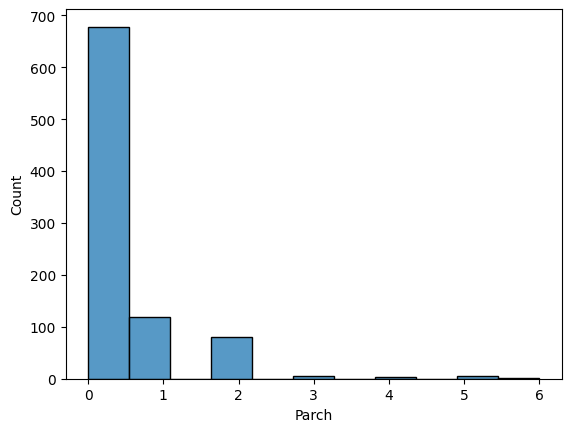

In [51]:
# Seaborn version (prettier)
sns.histplot(train['Parch'])
plt.show()

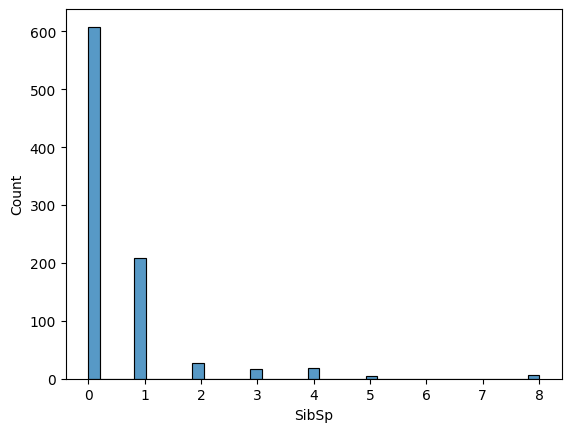

In [52]:
# Seaborn version (prettier)
sns.histplot(train['SibSp'])
plt.show()

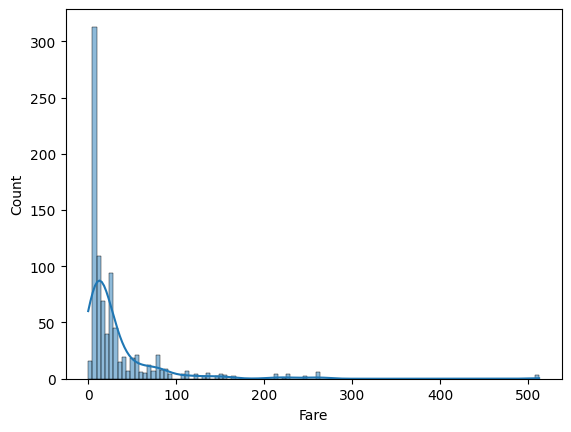

In [53]:
# Combined histogram + density
sns.histplot(train['Fare'], kde=True)
plt.show()

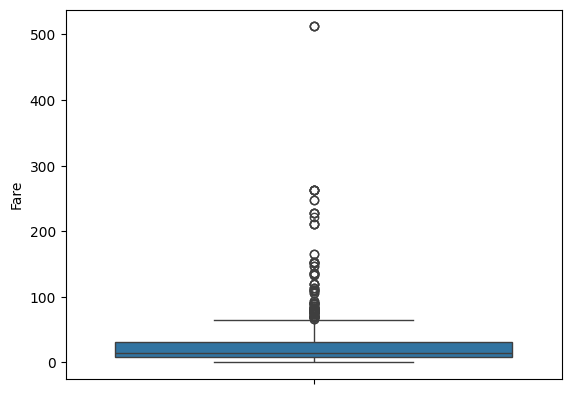

In [54]:
# Shows quartiles, median, outliers
sns.boxplot(y=train['Fare'])
plt.show()

### 2º) Clean the Data (Iterative)

Handle missing values, errors in the format, delete duplicates

In [55]:
def remove_outliers_iqr(df, columns):
    for column in columns: 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [56]:
train.info()

train_fe = train.copy(deep=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [57]:
train_fe.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [58]:
# First iteration, ignore age, remove main outliers, simply a model that predicts with the standarized/scaled data

# Drop Age (If the model does not work well, I will try to input the missing values and see what happens)
train_fe.drop(columns=['Age'], inplace=True)

# Remove outliers from the only continuous variable that has (SibSp and Parch do not have)
train_fe = remove_outliers_iqr(train_fe, ['Fare'])


In [59]:
scaler = MinMaxScaler()
# Min_max to normalize the quantitative variables (continuous and discrete)
train_fe[['Fare', 'SibSp', 'Parch']] = scaler.fit_transform(train_fe[['Fare', 'SibSp', 'Parch']])

In [60]:
train_fe.head(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,0.2,0.0,0.111538,2.0
2,1,3,1,0.0,0.0,0.121923,2.0
3,1,1,1,0.2,0.0,0.816923,2.0
4,0,3,0,0.0,0.0,0.123846,2.0
5,0,3,0,0.0,0.0,0.130128,1.0


In [61]:
train_fe = pd.get_dummies(train_fe, columns=['Pclass', 'Embarked'])

In [62]:
train_fe.head(5)

,Survived,Sex,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_0.0,Embarked_1.0,Embarked_2.0
0,0,0,0.2,0.0,0.111538,False,False,True,False,False,True
2,1,1,0.0,0.0,0.121923,False,False,True,False,False,True
3,1,1,0.2,0.0,0.816923,True,False,False,False,False,True
4,0,0,0.0,0.0,0.123846,False,False,True,False,False,True
5,0,0,0.0,0.0,0.130128,False,False,True,False,True,False


Do the same procedure to the test data

In [63]:
test_fe = test.copy(deep=True)

test_fe.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,2
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,2
4,3,1,22.0,1,1,12.2875,2


In [64]:
test_fe.drop(columns=['Age'], inplace=True)

test_fe[['Fare', 'SibSp', 'Parch']] = scaler.fit_transform(test_fe[['Fare', 'SibSp', 'Parch']])

test_fe = pd.get_dummies(test_fe, columns=['Pclass', 'Embarked'])

In [87]:
# Change boolean columns to integers

bool_cols = train_fe.select_dtypes(include='bool').columns
train_fe[bool_cols] = train_fe[bool_cols].astype(int)

### 3º) Build the model 

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [ ]:
X = train_fe.drop('Survived', axis=1).to_numpy() # Features
y = train_fe['Survived'].to_numpy() # Labels


To convert your DataFrame to a PyTorch DataLoader for training a neural network, you need to:

1- Separate features and labels.

2- Convert them to PyTorch tensors.

3- Wrap them in a TensorDataset.

4- Pass that to a DataLoader.

In [106]:
# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # use long for classification with nn.CrossEntropyLoss

# Wrap into a TensorDataset
# Create a DataLoader
train_dataloader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

In [107]:
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 10])
Shape of y: torch.Size([32]) torch.float32


In [ ]:
# Neural Network Definition
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout_rate=0.3):
        super(TitanicNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x
    
# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_X, batch_y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            batch_y = batch_y.unsqueeze(1)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    return train_losses, train_accuracies

def generate_predictions(model, )

In [120]:
# Initialize model
input_size = test_fe.shape[1]
model = TitanicNN(input_size=input_size)

In [121]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")

# Train the model
train_losses, train_accuracies = train_model(model, train_dataloader, criterion, optimizer, num_epochs=500)

Starting training...
Epoch [20/500], Loss: 0.4654, Accuracy: 0.7974
Epoch [40/500], Loss: 0.4470, Accuracy: 0.8052
Epoch [60/500], Loss: 0.4433, Accuracy: 0.8103
Epoch [80/500], Loss: 0.4398, Accuracy: 0.8065
Epoch [100/500], Loss: 0.4466, Accuracy: 0.8052
Epoch [120/500], Loss: 0.4399, Accuracy: 0.8039
Epoch [140/500], Loss: 0.4317, Accuracy: 0.8168
Epoch [160/500], Loss: 0.4402, Accuracy: 0.8116
Epoch [180/500], Loss: 0.4256, Accuracy: 0.8103
Epoch [200/500], Loss: 0.4286, Accuracy: 0.8181
Epoch [220/500], Loss: 0.4191, Accuracy: 0.8181
Epoch [240/500], Loss: 0.4347, Accuracy: 0.8103
Epoch [260/500], Loss: 0.4145, Accuracy: 0.8129
Epoch [280/500], Loss: 0.3992, Accuracy: 0.8168
Epoch [300/500], Loss: 0.4124, Accuracy: 0.8142
Epoch [320/500], Loss: 0.4095, Accuracy: 0.8219
Epoch [340/500], Loss: 0.4013, Accuracy: 0.8297
Epoch [360/500], Loss: 0.4193, Accuracy: 0.8116
Epoch [380/500], Loss: 0.4052, Accuracy: 0.8245
Epoch [400/500], Loss: 0.4058, Accuracy: 0.8219
Epoch [420/500], Loss: 

In [ ]:
# 1. Data Preprocessing
def preprocess_titanic_data(df):
    """Preprocess Titanic dataset"""
    df = df.copy()
    
    # Fill missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Create new features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Select features
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
    
    return df[features]

# 2. Neural Network Definition
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout_rate=0.3):
        super(TitanicNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

# 3. Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_X, batch_y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    return train_losses, train_accuracies

# 4. Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predicted = (outputs > 0.5).float()
            
            all_predictions.extend(predicted.numpy())
            all_targets.extend(batch_y.numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy, all_predictions, all_targets

# 5. Main Training Script
def main():
    # Load data (replace with your actual data loading)
    # For demo purposes, creating sample data structure
    # df = pd.read_csv('titanic.csv')
    
    # Sample data creation (replace with actual Titanic dataset)
    np.random.seed(42)
    n_samples = 891
    sample_data = {
        'Pclass': np.random.choice([1, 2, 3], n_samples),
        'Sex': np.random.choice([0, 1], n_samples),
        'Age': np.random.normal(30, 15, n_samples),
        'SibSp': np.random.poisson(0.5, n_samples),
        'Parch': np.random.poisson(0.4, n_samples),
        'Fare': np.random.lognormal(3, 1, n_samples),
        'Embarked': np.random.choice([0, 1, 2], n_samples),
        'FamilySize': np.random.randint(1, 8, n_samples),
        'IsAlone': np.random.choice([0, 1], n_samples),
        'Title': np.random.choice([0, 1, 2, 3], n_samples),
        'Survived': np.random.choice([0, 1], n_samples)
    }
    df = pd.DataFrame(sample_data)
    
    # Prepare features and target
    X = df.drop('Survived', axis=1).values
    y = df['Survived'].values.reshape(-1, 1)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    input_size = X_train.shape[1]
    model = TitanicNN(input_size=input_size)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    print("Starting training...")
    
    # Train the model
    train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=200)
    
    # Evaluate on test set
    test_accuracy, predictions, targets = evaluate_model(model, test_loader)
    
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(targets, predictions))
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler

# 6. Prediction Function for New Data
def predict_survival(model, scaler, passenger_data):
    """
    Predict survival for new passenger data
    passenger_data should be a dictionary with keys: 
    ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
    """
    model.eval()
    
    # Convert to array and scale
    features = np.array(list(passenger_data.values())).reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    # Convert to tensor and predict
    features_tensor = torch.FloatTensor(features_scaled)
    
    with torch.no_grad():
        prediction = model(features_tensor)
        probability = prediction.item()
        survival = 1 if probability > 0.5 else 0
    
    return survival, probability

if __name__ == "__main__":
    model, scaler = main()
    
    # Example prediction for a new passenger
    new_passenger = {
        'Pclass': 3,      # Third class
        'Sex': 0,         # Female (0) or Male (1)
        'Age': 25,        # Age 25
        'SibSp': 0,       # No siblings/spouses
        'Parch': 0,       # No parents/children
        'Fare': 7.25,     # Fare paid
        'Embarked': 2,    # Port of embarkation
        'FamilySize': 1,  # Family size
        'IsAlone': 1,     # Traveling alone
        'Title': 1        # Title (Miss, Mr, Mrs, etc.)
    }
    
    survival, probability = predict_survival(model, scaler, new_passenger)
    print(f"\nNew passenger prediction:")
    print(f"Survival: {'Survived' if survival else 'Did not survive'}")
    print(f"Probability of survival: {probability:.4f}")